In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../../data/emnist/emnist-balanced-train.csv',header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(112800, 785)

In [5]:
fig = df.iloc[0,:].to_numpy()[1:].reshape(28,28)

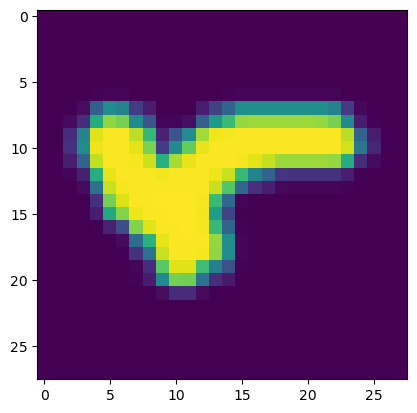

In [6]:
#show the image
import matplotlib.pyplot as plt
plt.imshow(fig.T)

In [7]:
#read mapping
mapping = pd.read_csv('../../data/emnist/emnist-balanced-mapping.txt', delimiter = ' ', index_col = 0, header = None)

In [8]:
# show image with label
label = df.iloc[0,0]
print(chr(int(mapping.loc[label].values)))

r


In [9]:
# read test data
df_test = pd.read_csv('../../data/emnist/emnist-balanced-test.csv')


In [10]:
# split data
X_train = df.iloc[:,1:].to_numpy()
y_train = df.iloc[:,0].to_numpy()
X_test = df_test.iloc[:,1:].to_numpy()
y_test = df_test.iloc[:,0].to_numpy()

In [11]:
# one hot encoding for labels
#y_train = pd.get_dummies(y_train).to_numpy()
#y_test = pd.get_dummies(y_test).to_numpy()

In [12]:
# reshape data
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

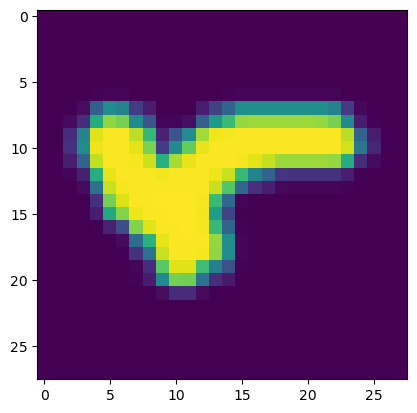

In [13]:
#transpose data
X_train = X_train.swapaxes(2, 3)
X_test = X_test.swapaxes(2, 3)
# display example
plt.imshow(X_train[0].reshape(28,28))

In [14]:
# normalize data
X_train = X_train/255
X_test = X_test/255

In [15]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch import optim
from torch.nn import functional as F
import d2l.torch as d2l

In [16]:
# convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [17]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小到 224x224
    transforms.ToTensor()           # 将图像转换为tensor
])

In [18]:
class EMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
# create dataset
train_dataset = EMNISTDataset(X_train, y_train)
test_dataset = EMNISTDataset(X_test, y_test)

In [20]:
# create dataloader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# define model

In [21]:
class Residual(nn.Module): 
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [22]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

In [23]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [24]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))

In [25]:
net = nn.Sequential(b1, b2, b3, b4,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), 
                    nn.Linear(256, 47))

In [26]:
x = torch.rand((1,1,28,28))
for layer in net:
    x = layer(x)
    print(type(layer).__name__,'output shape:\t', x.shape)
x

Sequential output shape:	 torch.Size([1, 64, 15, 15])
Sequential output shape:	 torch.Size([1, 64, 15, 15])
Sequential output shape:	 torch.Size([1, 128, 8, 8])
Sequential output shape:	 torch.Size([1, 256, 4, 4])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 256, 1, 1])
Flatten output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 47])


tensor([[ 0.3183, -0.2366,  0.4033,  0.6249,  0.2842, -0.7843, -0.8579,  0.9398,
          0.7371,  0.1122, -0.0153, -1.0219,  0.1152, -0.3305,  0.3747, -0.2443,
         -0.2028, -0.5191,  0.5866, -0.3000, -0.6292, -0.4383,  0.2166, -0.2164,
          0.7738, -0.6142, -0.2567,  0.4823,  0.7942, -0.6395, -0.0826,  0.4470,
          0.3563,  0.4413,  0.3344, -0.3261,  0.0900, -0.4939, -0.0597,  0.4270,
          0.6576,  0.2224, -0.9409,  0.3533,  0.2435,  0.2164, -0.4284]],
       grad_fn=<AddmmBackward0>)

loss 0.157, train acc 0.936, test acc 0.866
9473.3 examples/sec on cuda:0


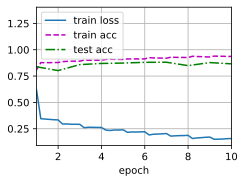

In [27]:
lr, num_epochs = 0.05, 10
d2l.train_ch6(net, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

In [28]:
# save a benchmark
torch.save(net.state_dict(), '../models/emnist-resnet-10-epochs.pth')

In [32]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2, stride=1, padding=1))
net[0] = b1

loss 0.222, train acc 0.914, test acc 0.872
2532.9 examples/sec on cuda:0


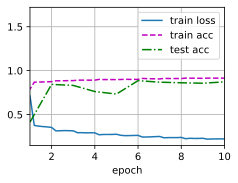

In [33]:
lr, num_epochs = 0.05, 10
d2l.train_ch6(net, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

In [34]:
# save a benchmark
torch.save(net.state_dict(), '../models/emnist-resnet-10-epochs-2.pth')

In [35]:
b5 = nn.Sequential(*resnet_block(256, 512, 2))
net.insert(4, b5)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

In [38]:
net[-1] = nn.Linear(512, 47)

loss 0.111, train acc 0.955, test acc 0.877
2068.0 examples/sec on cuda:0


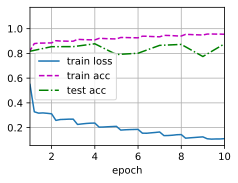

In [39]:
lr, num_epochs = 0.05, 10
d2l.train_ch6(net, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

In [40]:
# save a benchmark
torch.save(net.state_dict(), '../models/emnist-resnet-10-epochs-3.pth')

In [44]:
# load model
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), 
                    nn.Linear(512, 47)).to("cuda:0")
net.load_state_dict(torch.load('../models/emnist-resnet-10-epochs-3.pth'))

<All keys matched successfully>

In [45]:
# visualize the test result
def get_fashion_mnist_labels(labels):
    text_labels = [chr(int(mapping.loc[int(i)].values)) for i in labels]
    return text_labels

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.detach().numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

for X, y in test_loader:
    break
X = X.to("cuda:0")
y = y.to("cuda:0")

array([<Axes: title={'center': 'e\ne'}>, <Axes: title={'center': '9\n9'}>,
       <Axes: title={'center': 'Q\nQ'}>, <Axes: title={'center': 'q\n9'}>,
       <Axes: title={'center': 'X\nX'}>, <Axes: title={'center': 'E\nE'}>,
       <Axes: title={'center': 'B\nB'}>, <Axes: title={'center': '3\n3'}>,
       <Axes: title={'center': 'C\nI'}>], dtype=object)

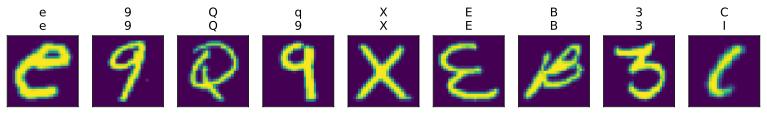

In [46]:
true_labels = get_fashion_mnist_labels(y)
pred_labels = get_fashion_mnist_labels(net(X).argmax(axis=1))
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_images(X[0:9].reshape((-1,28,28)).cpu(), 1, 9, titles=titles[0:9])
